# Scraping NBA Stats

## Motivation

The National Basketball Association (NBA) is a professional basketball league in North America, currently composed of 30 teams (29 in the US and 1 in Canada). It is the best basketball league in the world attracting the best players from around the world. Every year, around the midpoint of the season in February, they organize an exhibition game called the All-Star game. 24 of the best players in the league are chosen as the All-Stars to play in this game as voted by fans, media, fellow players and coaches. 

Being an all-star is regarded as a great achievement and therefore has been used as a metric in ranking the players historically. Usually team success and player performance are used by the voters in their selections. The goal of this study is to gather pre-all-star break data from the official NBA stats website to see if we can develop a machine learning model that can predict this year's all-stars based on per game stats.   

In [1]:
# Importing libraries
import os, sys
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import warnings

# Configure libraries
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

# Add base to path
sys.path.append('..')
sys.path.append('../../')

# Initialize dirs
data_dir = 'data'
input_data_dir = os.path.join(data_dir, 'input')
output_data_dir = os.path.join(data_dir, 'output')

## Pre All-Star Per Game Stats

As the All-Star selection is based on player performance up to that point, we need the stats from that portion of the season. The official NBA stats page has a filter called Pre All-Star for the season segment:

https://www.nba.com/stats/players/traditional/?sort=PLAYER_NAME&dir=-1&Season=2020-21&SeasonType=Regular%20Season&SeasonSegment=Pre%20All-Star

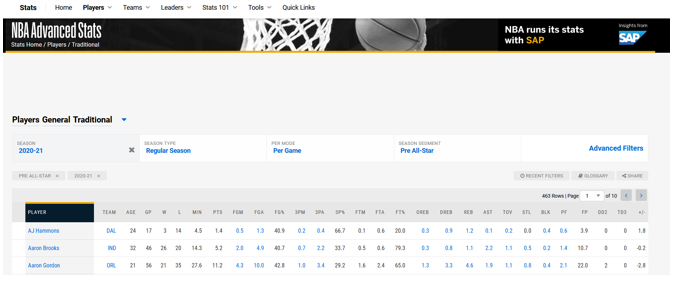

Upon inspection, it can be seen that the data is not stored on the HTML source page meaning that the python library beautiful soup cannot be utilized. There is an article by Ashwin M Murugappan titled "How Scraping NBA Stats is cooler than Michael Jordan" that describes this problem:

https://towardsdatascience.com/how-scraping-nba-stats-is-cooler-than-michael-jordan-49d7562ce3ef

The article explains that "...the NBA stats website was built with an AngularJS, which means that the site is rendered client-side instead of server-side...

The HTML which is rendered is only a template and it doesn’t hold any data, The Javascript in the server response fetches the data from an API and uses it to create the page client-side.

Basically, when you view the pages source code, you wouldn’t find the data but just a template of the webpage..."

As per the article, one needs to call the API endpoint using the URL and Query String Parameters. We can adopt this approach into our problem and define a for loop to gather data from multiple seasons:

In [2]:
# NBA Pre All-Star Stats go back to 1996-97 season
start_year=1997
end_year=2025

seasons=[]
for year in range(start_year, end_year):
    seasons.append(str(year-1)+'-'+str(year)[-2:])

In [3]:
# The request url stated under the headers of the website
url = 'https://stats.nba.com/stats/leaguedashplayerstats'

# The request header from the page
headers = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
    'Cache-Control': 'no-cache',
    'Connection': 'keep-alive',
    'Host': 'stats.nba.com',
    'Origin': 'https://www.nba.com',
    'Pragma': 'no-cache',
    'Referer': 'https://www.nba.com/',
    'sec-ch-ua-mobile': '?0',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-site',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

# Create empty dataframe to append to
players = pd.DataFrame()

# Loop through the seasons to request each page
for season in seasons:
    # The Query String Parameter from the page
    params = (
        ('College', ''),
        ('Conference', ''),
        ('Country', ''),
        ('DateFrom', ''),
        ('DateTo', ''),
        ('Division', ''),
        ('DraftPick', ''),
        ('DraftYear', ''),
        ('GameScope', ''),
        ('GameSegment', ''),
        ('Height', ''),
        ('LastNGames', '0'),
        ('LeagueID', '00'),
        ('Location',''),
        ('MeasureType', 'Base'),
        ('Month', '0'),
        ('OpponentTeamID', '0'),
        ('Outcome',''),
        ('PORound', '0'),
        ('PaceAdjust', 'N'),
        ('PerMode', 'PerGame'),
        ('Period', '0'),
        ('PlayerExperience', ''),
        ('PlayerPosition', ''),
        ('PlusMinus', 'N'),
        ('Rank', 'N'),
        ('Season', season),
        ('SeasonSegment', 'Pre All-Star'),
        ('SeasonType', 'Regular Season'),
        ('ShotClockRange', ''),
        ('StarterBench', ''),
        ('TeamID', '0'),
        ('TwoWay', '0'),
        ('VsConference', ''),
        ('VsDivision', ''),
        ('Weight', '')
    )
    # Make a get request
    response = get(url, headers=headers, params=params)

    # Web request into JSON format
    jsn = response.json()

    # Reformat the JSON to DataFrame
    df = pd.DataFrame(jsn['resultSets'][0]['rowSet'])

    # Assigning column headers
    df.columns = jsn['resultSets'][0]['headers']

    # Add season as a column
    df['SEASON'] = season

    # Append dataframes
    players = pd.concat([players, df], axis=0)

players.to_csv(os.path.join(input_data_dir, 'pre_allstar_player_stats.csv'), index=False)

The resulting dataframe includes the player stats up to the all-star break from the last 25 years: 

In [4]:
players.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON
0,920,A.C. Green,A.C.,1610612742,DAL,33.0000,45,15,30,0.3330,22.8000,2.2000,4.9000,0.4570,0.0000,0.1000,0.1670,1.2000,1.9000,0.5980,1.8000,4.1000,5.9000,0.8000,0.7000,0.6000,0.1000,0.6000,1.4000,0.0000,5.6000,-3.8000,15.1000,2,0,13.6000,95,208,33,314,178,219,235,149,270,276,260,208,177,336,77,72,72,261,313,223,341,111,317,48,225,371,198,103,13,209,1996-97
1,243,Aaron McKie,Aaron,1610612765,DET,24.0000,47,28,19,0.5960,18.9000,1.4000,3.9000,0.3570,0.5000,1.2000,0.4140,1.1000,1.3000,0.8390,0.4000,1.9000,2.3000,2.0000,1.1000,0.9000,0.4000,0.4000,1.6000,0.0000,4.4000,0.4000,12.8000,0,0,11.7000,27,65,163,140,221,296,271,367,150,170,55,214,235,60,338,221,256,129,229,130,163,194,280,135,275,150,229,176,13,240,1996-97
2,1425,Aaron Williams,Aaron,1610612763,VAN,25.0000,4,0,4,0.0000,9.7000,1.5000,2.8000,0.5450,0.0000,0.0000,0.0000,1.5000,2.5000,0.6000,1.3000,2.8000,4.0000,0.3000,1.3000,0.3000,1.3000,0.0000,1.5000,0.0000,4.5000,-1.0000,12.9000,0,0,11.8000,402,415,361,415,346,285,323,22,278,335,278,166,135,329,152,141,139,377,190,335,34,394,292,135,267,233,225,176,13,238,1996-97
3,768,Acie Earl,Acie,1610612749,MIL,27.0000,36,11,25,0.3060,12.4000,1.5000,4.1000,0.3690,0.0000,0.1000,0.0000,1.2000,1.9000,0.6470,0.9000,1.4000,2.3000,0.5000,0.9000,0.3000,0.7000,0.2000,1.5000,0.0000,4.3000,-1.6000,10.0000,0,0,9.1000,214,267,77,333,303,283,265,355,278,275,278,201,184,301,207,267,253,318,267,308,79,334,292,135,280,275,277,176,13,282,1996-97
4,228,Adam Keefe,Adam,1610612762,UTA,27.0000,43,30,13,0.6980,14.6000,1.3000,2.5000,0.5190,0.0000,0.0000,0.0000,1.0000,1.4000,0.6610,1.3000,2.3000,3.6000,0.6000,0.7000,0.5000,0.2000,0.2000,1.6000,0.0000,3.6000,1.7000,10.2000,1,0,9.2000,141,54,237,90,266,305,340,39,278,335,278,236,224,282,147,178,163,293,307,242,257,295,275,93,307,98,274,129,13,281,1996-97


In [5]:
players.tail()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON
535,1628380,Zach Collins,Zach,1610612759,SAS,26.0000,43,8,35,0.1860,24.2000,4.4000,9.3000,0.4750,0.8000,3.1000,0.2670,1.8000,2.3000,0.7820,1.8000,3.7000,5.5000,3.1000,2.0000,0.5000,0.7000,0.4000,3.3000,2.3000,11.5000,-6.7000,24.4000,2,0,23.4000,202,363,29,473,189,141,139,195,245,187,387,123,126,230,55,115,86,113,61,281,79,191,9,106,147,523,142,129,28,140,2023-24
536,203897,Zach LaVine,Zach,1610612741,CHI,29.0000,25,10,15,0.4000,34.9000,6.8000,15.0000,0.4520,2.4000,6.8000,0.3490,3.5000,4.1000,0.8540,0.3000,4.8000,5.2000,3.9000,2.1000,0.8000,0.3000,0.8000,2.3000,2.8000,19.5000,-3.7000,33.0000,1,0,33.2000,349,330,284,372,26,61,53,276,45,33,234,46,50,109,407,60,102,83,57,136,247,63,111,73,57,472,69,156,28,60,2023-24
537,1630192,Zeke Nnaji,Zeke,1610612743,DEN,23.0000,40,26,14,0.6500,9.6000,1.2000,2.7000,0.4390,0.1000,0.5000,0.2780,0.8000,1.2000,0.6810,1.2000,1.0000,2.1000,0.6000,0.6000,0.3000,0.6000,0.4000,1.5000,1.6000,3.3000,-3.4000,8.5000,0,0,7.7000,232,119,307,114,398,396,399,320,411,439,377,266,256,370,134,421,338,417,314,397,127,201,266,171,395,457,383,213,28,388,2023-24
538,1630533,Ziaire Williams,Ziaire,1610612763,MEM,22.0000,46,20,26,0.4350,19.3000,2.8000,7.1000,0.4010,1.2000,3.6000,0.3210,1.2000,1.5000,0.8210,0.7000,2.7000,3.4000,1.5000,1.3000,0.7000,0.2000,0.5000,1.7000,1.4000,8.0000,-4.6000,15.7000,1,0,15.8000,168,216,89,350,243,228,197,411,185,149,308,192,206,170,263,197,218,237,142,200,332,143,228,190,219,484,250,156,28,237,2023-24
539,1629627,Zion Williamson,Zion,1610612740,NOP,23.0000,44,26,18,0.5910,30.5000,8.8000,15.0000,0.5850,0.1000,0.3000,0.3640,4.7000,6.9000,0.6840,1.8000,3.8000,5.5000,4.8000,2.5000,0.9000,0.5000,1.7000,2.3000,5.0000,22.4000,1.3000,38.0000,7,0,35.6000,189,119,207,187,91,21,54,54,424,462,197,24,12,367,60,110,87,55,36,111,160,2,100,20,31,153,44,56,28,52,2023-24


## Team Wins Pre All-Star

As previously discussed, voters tend to reward winning teams with all-stars to acknowledge their success. So team wins at the time of voting plays as much role as the player performance. The data we acquired above does not include any information about how many games the player's team has played or how many of those games were won. This data can be found on another category in NBA stats website:

https://www.nba.com/stats/teams/traditional/?sort=TEAM_NAME&dir=-1&Season=2020-21&SeasonType=Regular%20Season&SeasonSegment=Pre%20All-Star

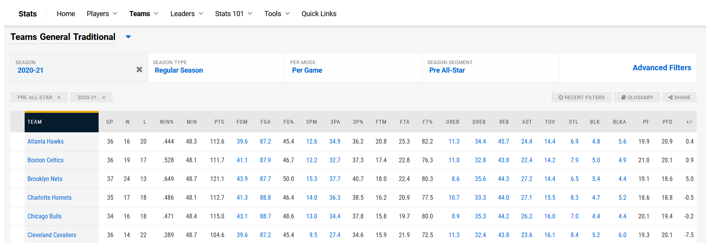

Using the same approach as the player data, we can write a for loop to gather team stats from the past 25 years:

In [6]:
# The request url stated under the headers of the website
url = 'https://stats.nba.com/stats/leaguedashteamstats'

# The request header from the page
headers = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
    'Cache-Control': 'no-cache',
    'Connection': 'keep-alive',
    'Host': 'stats.nba.com',
    'Origin': 'https://www.nba.com',
    'Pragma': 'no-cache',
    'Referer': 'https://www.nba.com/',
    'sec-ch-ua-mobile': '?0',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-site',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

# Create empty dataframe to append to
teams = pd.DataFrame()

# Loop through the seasons to request each page
for season in seasons:
    # The Query String Parameter from the page
    params = (
        ('Conference', ''),
        ('DateFrom', ''),
        ('DateTo', ''),
        ('Division', ''),
        ('GameScope', ''),
        ('GameSegment', ''),
        ('LastNGames', '0'),
        ('LeagueID', '00'),
        ('Location',''),
        ('MeasureType', 'Base'),
        ('Month', '0'),
        ('OpponentTeamID', '0'),
        ('Outcome',''),
        ('PORound', '0'),
        ('PaceAdjust', 'N'),
        ('PerMode', 'PerGame'),
        ('Period', '0'),
        ('PlayerExperience', ''),
        ('PlayerPosition', ''),
        ('PlusMinus', 'N'),
        ('Rank', 'N'),
        ('Season', season),
        ('SeasonSegment', 'Pre All-Star'),
        ('SeasonType', 'Regular Season'),
        ('ShotClockRange', ''),
        ('StarterBench', ''),
        ('TeamID', '0'),
        ('TwoWay', '0'),
        ('VsConference', ''),
        ('VsDivision', '')
    )
    # Make a get request
    response = get(url, headers=headers, params=params)

    # Web request into JSON format
    jsn = response.json()

    # Reformat the JSON to DataFrame
    df = pd.DataFrame(jsn['resultSets'][0]['rowSet'])

    # Assigning column headers
    df.columns = jsn['resultSets'][0]['headers']

    # Add season as a column
    df['SEASON'] = season

    # Append dataframes
    teams = pd.concat([teams, df], axis=0)

teams.to_csv(os.path.join(input_data_dir, 'pre_allstar_team_stats.csv'), index=False)

Now we have the necessary data on the teams:

In [7]:
teams.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,SEASON
0,1610612737,Atlanta Hawks,46,31,15,0.6740,48.4000,33.8000,77.0000,0.4380,7.9000,21.9000,0.3600,17.7000,23.3000,0.7600,12.5000,29.5000,42.0000,17.8000,14.7000,7.6000,5.4000,4.1000,19.3000,0.1000,93.2000,5.1000,18,9,7,8,12,27,21,23,1,1,13,20,25,4,14,10,10,29,3,23,9,4,1,27,25,5,1996-97
1,1610612738,Boston Celtics,46,11,35,0.2390,48.7000,37.7000,85.1000,0.4430,4.8000,13.8000,0.3490,18.9000,25.3000,0.7470,13.3000,27.1000,40.4000,21.3000,16.7000,10.3000,4.2000,6.7000,23.4000,0.2000,99.2000,-5.3000,18,27,28,28,4,3,2,20,23,23,19,12,13,10,8,25,20,17,21,2,23,29,22,15,7,24,1996-97
2,1610612766,Charlotte Hornets,48,29,19,0.6040,48.2000,35.4000,77.3000,0.4590,7.0000,16.4000,0.4240,18.4000,24.1000,0.7630,11.2000,28.0000,39.1000,23.9000,14.8000,7.0000,3.9000,4.6000,21.3000,0.2000,96.2000,-0.1000,3,10,10,10,25,16,20,9,8,16,1,15,21,3,28,19,25,4,5,26,26,9,8,8,13,14,1996-97
3,1610612741,Chicago Bulls,48,42,6,0.8750,48.1000,39.8000,84.4000,0.4710,6.3000,17.3000,0.3610,16.5000,22.3000,0.7430,14.6000,29.6000,44.3000,25.4000,13.1000,8.8000,3.8000,3.5000,19.5000,0.1000,102.3000,11.8000,3,1,1,1,29,1,3,2,12,12,12,26,27,11,3,7,3,2,1,6,27,2,2,22,1,1,1996-97
4,1610612739,Cleveland Cavaliers,47,25,22,0.5320,48.4000,33.6000,73.7000,0.4550,6.3000,16.0000,0.3930,14.8000,20.6000,0.7180,11.4000,26.7000,38.1000,21.3000,14.8000,8.4000,4.3000,4.6000,23.3000,0.3000,88.1000,3.4000,13,11,12,12,17,28,29,14,11,17,3,28,28,22,26,27,29,16,4,12,21,8,21,3,29,9,1996-97


## All-Star Selections

The feature we are trying to predict will be the all-star selections, so we need to know who the all-stars were in these past 25 years in order to train our model. Unfortunately, this information is not a part of the datasets we have gathered in the previous steps. The "best-organized" version of these rosters can be found on the RealGM website:

https://basketball.realgm.com/nba/allstar/game/rosters/2021

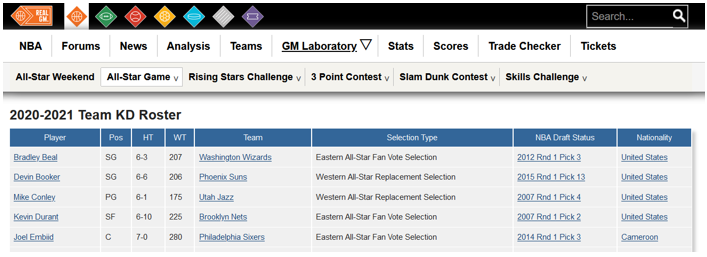

Upon inspection, we can see that the data is stored on the html page in this case:

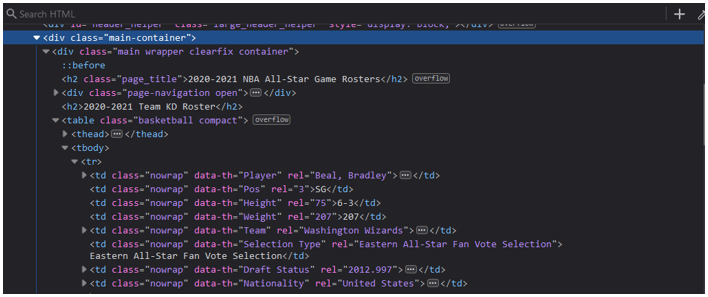

Therefore, we can use the BeautifulSoup library this time to access the necessary data more directly:

In [8]:
# Starting with empty lists
name = []
pos = []
height = []
weight = []
team = []
select = []
draft = []
nation = []
years = []

# Create empty dataframe to append to
allstar = pd.DataFrame()

# Loop through the years
for year in range(start_year, end_year):
    # Make a get request
    response = get('https://basketball.realgm.com/nba/allstar/game/rosters/' + str(year))
    # Parse the content of the request with BeautifulSoup
    page_html = BeautifulSoup(response.text, 'html.parser')
    # Select all the player containers from a single page
    containers = page_html.findAll('td', attrs={
        'data-th': ['Player', 'Pos', 'Height', 'Weight', 'Team', 'Selection Type', 'Draft Status', 'Nationality']})
    
    # Extract data from individual containers
    for i in range(0, len(containers), 8):
        years.append(year)
        name.append(containers[i].a.text)
        pos.append(containers[i+1].text)
        height.append(containers[i+2].text)
        weight.append(containers[i+3].text)
        team.append(containers[i+4].a.text)
        select.append(containers[i+5].text)
        draft.append(containers[i+6].a.text)
        nation.append(containers[i+7].text)

# Add data into a dataframe
allstar = pd.DataFrame({'YEAR': years,
    'PLAYER': name,
    'POS': pos,
    'HT': height,
    'WT': weight,
    'TEAM': team,
    'SELECTION': select,
    'DRAFT': draft,
    'NATIONALITY': nation
})

allstar.to_csv(os.path.join(input_data_dir, 'allstar_selection.csv'), index=False)

We now have the required data on the all-stars with some additional information on their positions, selection types and draft positions. 

In [9]:
allstar.head()

,YEAR,PLAYER,POS,HT,WT,TEAM,SELECTION,DRAFT,NATIONALITY
0,1997,Vin Baker,PF,6-11,240,Milwaukee Bucks,Eastern All-Star Coaches Selection,1993 Rnd 1 Pick 8,United States
1,1997,Terrell Brandon,PG,5-11,180,Cleveland Cavaliers,Eastern All-Star Coaches Selection,1991 Rnd 1 Pick 11,United States
2,1997,Joe Dumars,SG,6-3,190,Detroit Pistons,Eastern All-Star Replacement Selection,1985 Rnd 1 Pick 18,United States
3,1997,Patrick Ewing,C,7-0,240,New York Knicks,Eastern All-Star Fan Vote Selection,1985 Rnd 1 Pick 1,United StatesJamaica
4,1997,Penny Hardaway,PG,6-7,195,Orlando Magic,Eastern All-Star Fan Vote Selection,1993 Rnd 1 Pick 3,United States


## Conclusions

In this project, we scraped data from NBA Stats and the RealGM websites in order to gather information on the all-star selections from the past 25 years. Using pages with 2 different endpoints has enabled us to utilize 2 different methods for data scraping. As a result, we have a good amount of data with the necessary information that we can work on to make predictions. 